In [102]:
import numpy as np
import pandas as pd
from scipy.stats import bernoulli
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from torch import optim as optim
import matplotlib.pyplot as plt
import dataset_script
from dataset_script import gen_random_unitary_trans, apply_random_unitary_trans, make_training_set, make_easy_test_set,  make_med_test_set
from dataset_script import make_hard_test_set


ImportError: cannot import name 'make_hard_test_set' from 'dataset_script' (/Users/ismaelrobles-razzaq/cs_projects/research/rnn_somatosensory/dataset_script.py)

In [62]:
X, y_easy_c1, y_easy_c2, y_easy_c3, y_med_c12, y_med_c13, y_med_c23 = make_training_set()
X_test_easy, y_easy_c1_test, y_easy_c2_test, y_easy_c3_test = make_easy_test_set()
X_test_med, y_med_c12_test, y_med_c13_test, y_med_c23_test = make_med_test_set()


In [63]:
print(X.shape, y_easy_c1.shape, y_easy_c2.shape, y_easy_c3.shape)
print(X_test_easy.shape, y_easy_c3_test.shape)
print(X_test_med.shape, y_med_c12_test.shape)

(3200, 20, 3) (3200,) (3200,) (3200,)
(320, 20, 3) (320,)
(320, 20, 3) (320,)


In [64]:
transformation = gen_random_unitary_trans()
X = apply_random_unitary_trans(X, transformation)
X_test_easy = apply_random_unitary_trans(X_test_easy, transformation)
X_test_med = apply_random_unitary_trans(X_test_med, transformation)

In [65]:
print(X.shape, y_easy_c1.shape, y_easy_c2.shape, y_easy_c3.shape)
print(X_test_easy.shape, y_easy_c3_test.shape)
print(X_test_med.shape, y_med_c12_test.shape)

(3200, 20, 3) (3200,) (3200,) (3200,)
(320, 20, 3) (320,)
(320, 20, 3) (320,)


In [66]:
class WhiskerDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [77]:
# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_easy_c1_tensor = torch.tensor(y_easy_c1, dtype=torch.long)
y_easy_c2_tensor = torch.tensor(y_easy_c2, dtype=torch.long)
y_easy_c3_tensor = torch.tensor(y_easy_c3, dtype=torch.long)
y_med_c12_tensor = torch.tensor(y_med_c12, dtype=torch.long)
y_med_c13_tensor = torch.tensor(y_med_c13, dtype=torch.long)
y_med_c23_tensor = torch.tensor(y_med_c23, dtype=torch.long)


# Convert easy tests to tensors
X_test_easy_tensor = torch.tensor(X_test_easy, dtype=torch.float32)
y_easy_c1_test_tensor = torch.tensor(y_easy_c1_test, dtype=torch.long)
y_easy_c2_test_tensor = torch.tensor(y_easy_c2_test, dtype=torch.long)
y_easy_c3_test_tensor = torch.tensor(y_easy_c3_test, dtype=torch.long)


# Convert medium tests to tensors
X_test_med_tensor = torch.tensor(X_test_med, dtype=torch.float32)
y_med_c12_test_tensor = torch.tensor(y_med_c12_test, dtype=torch.long)
y_med_c13_test_tensor = torch.tensor(y_med_c13_test, dtype=torch.long)
y_med_c23_test_tensor = torch.tensor(y_med_c23_test, dtype=torch.long)


In [68]:
print(X_test_easy_tensor.shape, X_test_med_tensor.shape)
print(y_easy_c1_test_tensor.shape, y_med_c12_test_tensor.shape)

torch.Size([320, 20, 3]) torch.Size([320, 20, 3])
torch.Size([320]) torch.Size([320])


In [69]:
def split_dataset(X, y, test_size=0.2, random_state=42):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_val, y_train, y_val

In [93]:
# Easy data prep
# Split the dataset for easy tasks
X_train_c1, X_val_c1, y_train_c1, y_val_c1 = split_dataset(X_tensor, y_easy_c1_tensor)
X_train_c2, X_val_c2, y_train_c2, y_val_c2 = split_dataset(X_tensor, y_easy_c2_tensor)
X_train_c3, X_val_c3, y_train_c3, y_val_c3 = split_dataset(X_tensor, y_easy_c3_tensor)

# Create Dataset and DataLoader for each split (easy tasks)
train_dataset_c1 = WhiskerDataset(X_train_c1, y_train_c1)
val_dataset_c1 = WhiskerDataset(X_val_c1, y_val_c1)

train_dataset_c2 = WhiskerDataset(X_train_c2, y_train_c2)
val_dataset_c2 = WhiskerDataset(X_val_c2, y_val_c2)

train_dataset_c3 = WhiskerDataset(X_train_c3, y_train_c3)
val_dataset_c3 = WhiskerDataset(X_val_c3, y_val_c3)

train_dataloader_c1 = DataLoader(train_dataset_c1, batch_size=20, shuffle=True)
val_dataloader_c1 = DataLoader(val_dataset_c1, batch_size=20, shuffle=False)

train_dataloader_c2 = DataLoader(train_dataset_c2, batch_size=20, shuffle=True)
val_dataloader_c2 = DataLoader(val_dataset_c2, batch_size=20, shuffle=False)

train_dataloader_c3 = DataLoader(train_dataset_c3, batch_size=20, shuffle=True)
val_dataloader_c3 = DataLoader(val_dataset_c3, batch_size=20, shuffle=False)

# Create test Dataset and DataLoader for easy tasks
test_dataset_c1 = WhiskerDataset(X_test_easy_tensor, y_easy_c1_test_tensor)
test_dataloader_c1 = DataLoader(test_dataset_c1, batch_size=20, shuffle=False)

test_dataset_c2 = WhiskerDataset(X_test_easy_tensor, y_easy_c2_test_tensor)
test_dataloader_c2 = DataLoader(test_dataset_c2, batch_size=20, shuffle=False)

test_dataset_c3 = WhiskerDataset(X_test_easy_tensor, y_easy_c3_test_tensor)
test_dataloader_c3 = DataLoader(test_dataset_c3, batch_size=20, shuffle=False)
# easy dataloader + dataset stuff here


In [71]:
# hyperparams

device = "cuda" if torch.cuda.is_available() else "cpu"



input_size = 3
sequence_len = 20
num_layers = 1
hidden_size = 60
num_classes = 2
batch_size = 20
max_epochs = 2 # variables num epochs
learning_rate = 0.005
weight_decay = 10 ** -10 # l2 regularization term
max_epochs_easy = 20
max_epochs_medium = 40
max_epochs_hard = 100

In [72]:
# Defining RNN class
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, sequence_len):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.sequence_len = sequence_len
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)
        noise = torch.randn_like(out) # strength of noise is always 1
        out += noise
        out = F.relu(out)

        

        # Pass the output of the last time step to the fully connected layer
        out = self.fc(out[:, -1, :])
        return out



In [95]:
# creating easy models, loss functions, optimizers, and combining into list for training function input
model_easy_c1 = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes, sequence_len=sequence_len).to(device)
model_easy_c2 = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes, sequence_len=sequence_len).to(device)
model_easy_c3 = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes, sequence_len=sequence_len).to(device)

loss_easy_c1 = nn.CrossEntropyLoss()
loss_easy_c2 = nn.CrossEntropyLoss()
loss_easy_c3 = nn.CrossEntropyLoss()

optim_easy_c1 = optim.Adam(params=model_easy_c1.parameters(), lr=learning_rate, weight_decay=weight_decay)
optim_easy_c2 = optim.Adam(params=model_easy_c2.parameters(), lr=learning_rate, weight_decay=weight_decay)
optim_easy_c3 = optim.Adam(params=model_easy_c3.parameters(), lr=learning_rate, weight_decay=weight_decay)

easy_data_list = [
(model_easy_c1, loss_easy_c1, optim_easy_c1, "Easy Task 1", train_dataloader_c1, val_dataloader_c1, test_dataloader_c1, max_epochs_easy), \
(model_easy_c2, loss_easy_c2, optim_easy_c2, "Easy Task 2", train_dataloader_c2, val_dataloader_c2, test_dataloader_c2, max_epochs_easy), \
(model_easy_c3, loss_easy_c3, optim_easy_c3, "Easy Task 3", train_dataloader_c3, val_dataloader_c3, test_dataloader_c3, max_epochs_easy)
]

In [83]:
# medium task data prep
X_train_c12, X_val_c12, y_train_c12, y_val_c12 = split_dataset(X_tensor, y_med_c12_tensor)
X_train_c13, X_val_c13, y_train_c13, y_val_c13 = split_dataset(X_tensor, y_med_c13_tensor)
X_train_c23, X_val_c23, y_train_c23, y_val_c23 = split_dataset(X_tensor, y_med_c23_tensor)

# Create Dataset and DataLoader for each split
train_dataset_c12_med = WhiskerDataset(X_train_c12, y_train_c12)
val_dataset_c12_med = WhiskerDataset(X_val_c12, y_val_c12)

train_dataset_c13_med = WhiskerDataset(X_train_c13, y_train_c13)
val_dataset_c13_med = WhiskerDataset(X_val_c13, y_val_c13)

train_dataset_c23_med = WhiskerDataset(X_train_c23, y_train_c23)
val_dataset_c23_med = WhiskerDataset(X_val_c23, y_val_c23)

train_dataloader_c12_med = DataLoader(train_dataset_c12_med, batch_size=20, shuffle=True)
val_dataloader_c12_med = DataLoader(val_dataset_c12_med, batch_size=20, shuffle=False)

train_dataloader_c13_med = DataLoader(train_dataset_c13_med, batch_size=20, shuffle=True)
val_dataloader_c13_med = DataLoader(val_dataset_c13_med, batch_size=20, shuffle=False)

train_dataloader_c23_med = DataLoader(train_dataset_c23_med, batch_size=20, shuffle=True)
val_dataloader_c23_med = DataLoader(val_dataset_c23_med, batch_size=20, shuffle=False)


# Create test Dataset and DataLoader
test_dataset_c12_med = WhiskerDataset(X_test_med_tensor, y_med_c12_test_tensor)
test_dataloader_c12_med = DataLoader(test_dataset_c12_med, batch_size=20, shuffle=False)

test_dataset_c13_med = WhiskerDataset(X_test_med_tensor, y_med_c13_test_tensor)
test_dataloader_c13_med = DataLoader(test_dataset_c13_med, batch_size=20, shuffle=False)

test_dataset_c23_med = WhiskerDataset(X_test_med_tensor, y_med_c23_test_tensor)
test_dataloader_c23_med = DataLoader(test_dataset_c23_med, batch_size=20, shuffle=False)


In [86]:
# creating medium models, loss functions, optimizers, and combining into list for training function input

model_med_c12 = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes, sequence_len=sequence_len).to(device)
model_med_c13 = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes, sequence_len=sequence_len).to(device)
model_med_c23 = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes, sequence_len=sequence_len).to(device)

loss_med_c12 = nn.CrossEntropyLoss()
loss_med_c13 = nn.CrossEntropyLoss()
loss_med_c23 = nn.CrossEntropyLoss()

optim_med_c12 = optim.Adam(params=model_med_c12.parameters(), lr=learning_rate, weight_decay=weight_decay)
optim_med_c13 = optim.Adam(params=model_med_c13.parameters(), lr=learning_rate, weight_decay=weight_decay)
optim_med_c23 = optim.Adam(params=model_med_c23.parameters(), lr=learning_rate, weight_decay=weight_decay)

med_model_data = [
(model_med_c12, loss_med_c12, optim_med_c12, "Medium Task 1", train_dataloader_c12_med, val_dataloader_c12_med, test_dataloader_c12_med, max_epochs_medium),
(model_med_c13, loss_med_c13, optim_med_c13, "Medium Task 2", train_dataloader_c13_med, val_dataloader_c13_med, test_dataloader_c13_med, max_epochs_medium),
(model_med_c23, loss_med_c23, optim_med_c23, "Medium Task 3", train_dataloader_c23_med, val_dataloader_c23_med, test_dataloader_c23_med, max_epochs_medium)

]

In [90]:
def train_model(data_list):    
    for model, loss_fn, optimizer, task_label, train_dataloader, val_dataloader, test_dataloader, max_epochs in data_list:
        train_losses = []
        val_losses = []
        val_accuracies = []
        test_accuracies = []  # Initialize list for storing test accuracies

        target_loss = 1e-3
        max_epochs = max_epochs  # Set the appropriate number of epochs based on the task complexity

        for epoch in range(max_epochs):
            # Training loopx
            model.train()
            train_loss = 0
            for batch_idx, (data, target) in enumerate(train_dataloader):
                data = data.to(device)
                target = target.to(device)

                scores = model(data)
                loss = loss_fn(scores, target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
            
            # Calculate average training loss for the epoch
            train_loss /= len(train_dataloader)
            train_losses.append(train_loss)
            
            # Validation loop
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in val_dataloader:
                    data = data.to(device)
                    target = target.to(device)

                    scores = model(data)
                    loss = loss_fn(scores, target)
                    val_loss += loss.item()
                    _, predicted = torch.max(scores.data, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()
            
            # Calculate average validation loss and accuracy for the epoch
            val_loss /= len(val_dataloader)
            val_losses.append(val_loss)
            accuracy = 100 * correct / total
            val_accuracies.append(accuracy)
            
            print(f"Epoch [{epoch+1}/{max_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")
            
            # Test loop (for test accuracy)
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in test_dataloader:  # Using the test dataloader
                    data = data.to(device)
                    target = target.to(device)

                    scores = model(data)
                    _, predicted = torch.max(scores.data, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()
            
            # Calculate test accuracy
            test_accuracy = 100 * correct / total
            test_accuracies.append(test_accuracy)
            
            print(f"Test Accuracy: {test_accuracy:.2f}%")
            
            # Check for early stopping
            if train_loss <= target_loss:
                print(f"Target loss of {target_loss} reached at epoch {epoch+1}")
                break


        # Plot training and validation loss
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
        plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(task_label + ' Training and Validation Loss')
        plt.legend()
        plt.show()


Epoch [1/40], Train Loss: 0.7077, Val Loss: 0.6908, Val Accuracy: 54.38%
Test Accuracy: 52.19%
Epoch [2/40], Train Loss: 0.7049, Val Loss: 0.6916, Val Accuracy: 51.72%
Test Accuracy: 48.75%
Epoch [3/40], Train Loss: 0.7058, Val Loss: 0.7030, Val Accuracy: 49.84%
Test Accuracy: 52.50%
Epoch [4/40], Train Loss: 0.7049, Val Loss: 0.7084, Val Accuracy: 50.31%
Test Accuracy: 48.75%
Epoch [5/40], Train Loss: 0.7023, Val Loss: 0.7044, Val Accuracy: 50.16%
Test Accuracy: 52.81%
Epoch [6/40], Train Loss: 0.7079, Val Loss: 0.6929, Val Accuracy: 53.12%
Test Accuracy: 49.06%
Epoch [7/40], Train Loss: 0.6382, Val Loss: 0.6342, Val Accuracy: 62.81%
Test Accuracy: 53.44%
Epoch [8/40], Train Loss: 0.7118, Val Loss: 0.7170, Val Accuracy: 50.94%
Test Accuracy: 50.62%
Epoch [9/40], Train Loss: 0.7147, Val Loss: 0.7003, Val Accuracy: 50.62%
Test Accuracy: 55.62%
Epoch [10/40], Train Loss: 0.7081, Val Loss: 0.7038, Val Accuracy: 50.47%
Test Accuracy: 46.56%
Epoch [11/40], Train Loss: 0.7088, Val Loss: 0.70

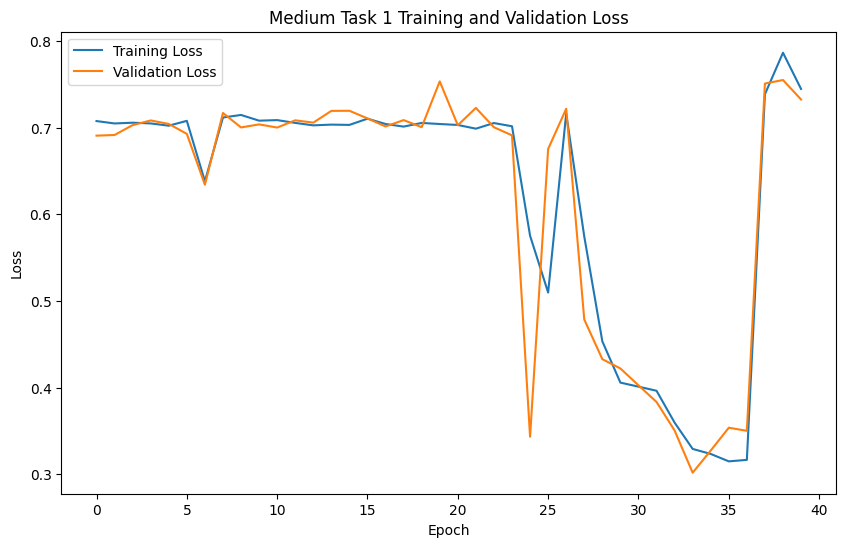

Epoch [1/40], Train Loss: 0.0150, Val Loss: 0.0174, Val Accuracy: 99.84%
Test Accuracy: 61.56%
Epoch [2/40], Train Loss: 0.0111, Val Loss: 0.0060, Val Accuracy: 100.00%
Test Accuracy: 61.25%
Epoch [3/40], Train Loss: 0.0084, Val Loss: 0.0108, Val Accuracy: 99.84%
Test Accuracy: 60.00%
Epoch [4/40], Train Loss: 0.0093, Val Loss: 0.0100, Val Accuracy: 99.69%
Test Accuracy: 60.62%
Epoch [5/40], Train Loss: 0.0148, Val Loss: 0.0091, Val Accuracy: 99.69%
Test Accuracy: 61.56%
Epoch [6/40], Train Loss: 0.0097, Val Loss: 0.0061, Val Accuracy: 99.84%
Test Accuracy: 60.62%
Epoch [7/40], Train Loss: 0.0083, Val Loss: 0.0134, Val Accuracy: 99.53%
Test Accuracy: 59.69%
Epoch [8/40], Train Loss: 0.0050, Val Loss: 0.0115, Val Accuracy: 99.53%
Test Accuracy: 58.12%
Epoch [9/40], Train Loss: 0.0095, Val Loss: 0.0151, Val Accuracy: 99.53%
Test Accuracy: 61.56%
Epoch [10/40], Train Loss: 0.0047, Val Loss: 0.0048, Val Accuracy: 99.84%
Test Accuracy: 60.00%
Epoch [11/40], Train Loss: 0.0080, Val Loss: 0.0

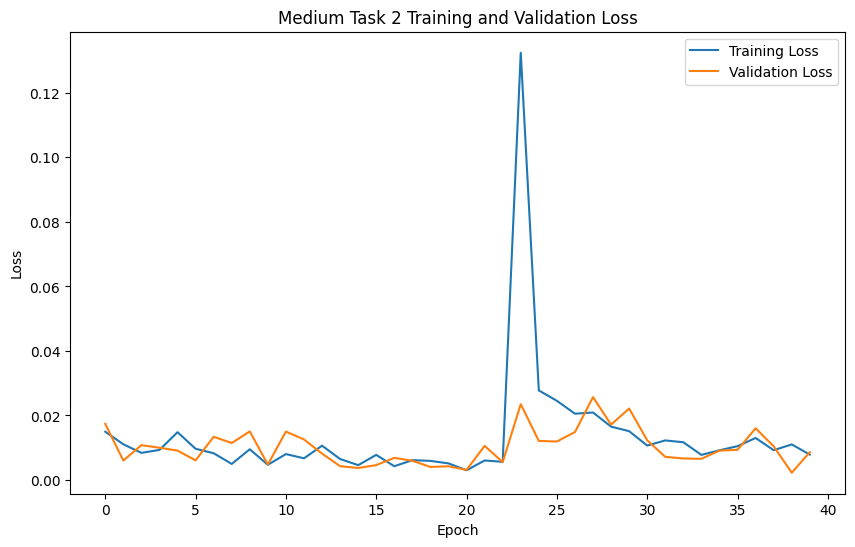

Epoch [1/40], Train Loss: 0.6871, Val Loss: 0.7088, Val Accuracy: 48.75%
Test Accuracy: 50.00%
Epoch [2/40], Train Loss: 0.7180, Val Loss: 0.7582, Val Accuracy: 44.53%
Test Accuracy: 50.00%
Epoch [3/40], Train Loss: 0.7063, Val Loss: 0.6943, Val Accuracy: 53.91%
Test Accuracy: 48.75%
Epoch [4/40], Train Loss: 0.7067, Val Loss: 0.7289, Val Accuracy: 47.50%
Test Accuracy: 46.25%
Epoch [5/40], Train Loss: 0.7026, Val Loss: 0.6991, Val Accuracy: 51.56%
Test Accuracy: 47.19%
Epoch [6/40], Train Loss: 0.7098, Val Loss: 0.7526, Val Accuracy: 45.62%
Test Accuracy: 48.75%
Epoch [7/40], Train Loss: 0.7077, Val Loss: 0.7019, Val Accuracy: 50.62%
Test Accuracy: 52.50%
Epoch [8/40], Train Loss: 0.7059, Val Loss: 0.6988, Val Accuracy: 50.00%
Test Accuracy: 50.31%
Epoch [9/40], Train Loss: 0.7145, Val Loss: 0.7324, Val Accuracy: 45.16%
Test Accuracy: 47.50%
Epoch [10/40], Train Loss: 0.7083, Val Loss: 0.7035, Val Accuracy: 48.75%
Test Accuracy: 45.31%
Epoch [11/40], Train Loss: 0.7065, Val Loss: 0.69

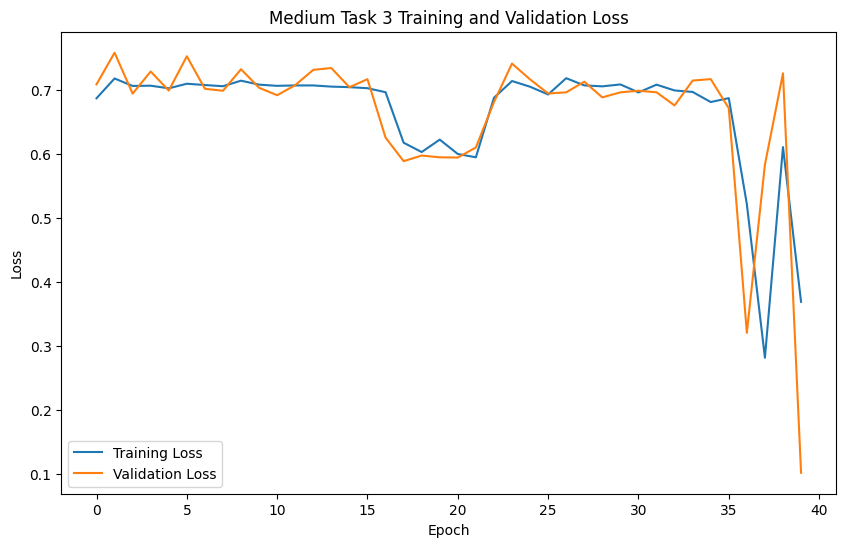

In [92]:
train_model(med_model_data)

Epoch [1/20], Train Loss: 0.0803, Val Loss: 0.0033, Val Accuracy: 100.00%
Test Accuracy: 68.75%
Epoch [2/20], Train Loss: 0.0024, Val Loss: 0.0011, Val Accuracy: 100.00%
Test Accuracy: 67.50%
Epoch [3/20], Train Loss: 0.0010, Val Loss: 0.0009, Val Accuracy: 100.00%
Test Accuracy: 65.31%
Target loss of 0.001 reached at epoch 3


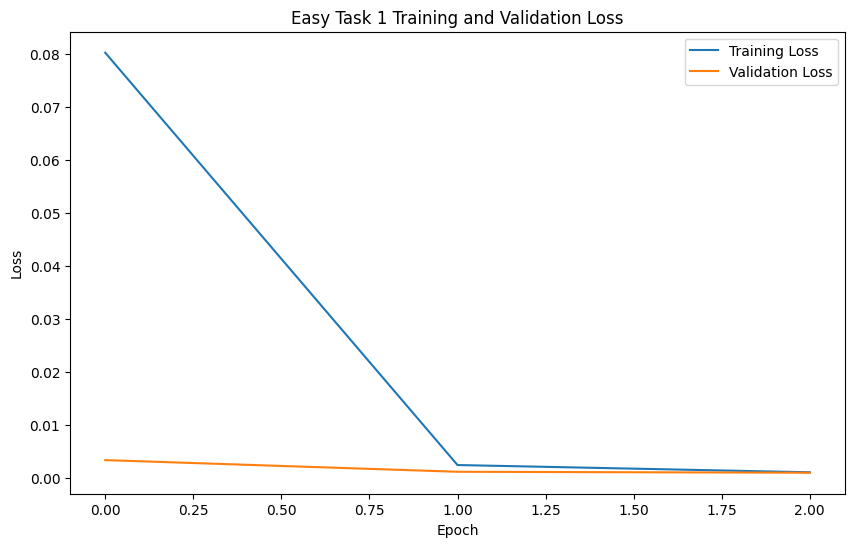

Epoch [1/20], Train Loss: 0.0658, Val Loss: 0.0023, Val Accuracy: 100.00%
Test Accuracy: 70.62%
Epoch [2/20], Train Loss: 0.0015, Val Loss: 0.0009, Val Accuracy: 100.00%
Test Accuracy: 69.38%
Epoch [3/20], Train Loss: 0.0008, Val Loss: 0.0005, Val Accuracy: 100.00%
Test Accuracy: 71.88%
Target loss of 0.001 reached at epoch 3


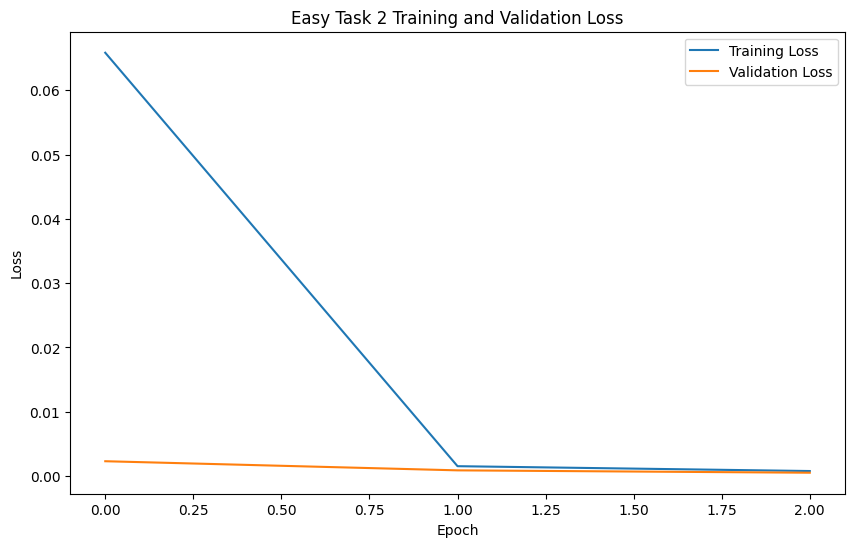

Epoch [1/20], Train Loss: 0.1966, Val Loss: 0.0072, Val Accuracy: 100.00%
Test Accuracy: 75.00%
Epoch [2/20], Train Loss: 0.0049, Val Loss: 0.0030, Val Accuracy: 100.00%
Test Accuracy: 73.44%
Epoch [3/20], Train Loss: 0.0021, Val Loss: 0.0016, Val Accuracy: 100.00%
Test Accuracy: 71.56%
Epoch [4/20], Train Loss: 0.0014, Val Loss: 0.0011, Val Accuracy: 100.00%
Test Accuracy: 73.75%
Epoch [5/20], Train Loss: 0.0009, Val Loss: 0.0009, Val Accuracy: 100.00%
Test Accuracy: 72.19%
Target loss of 0.001 reached at epoch 5


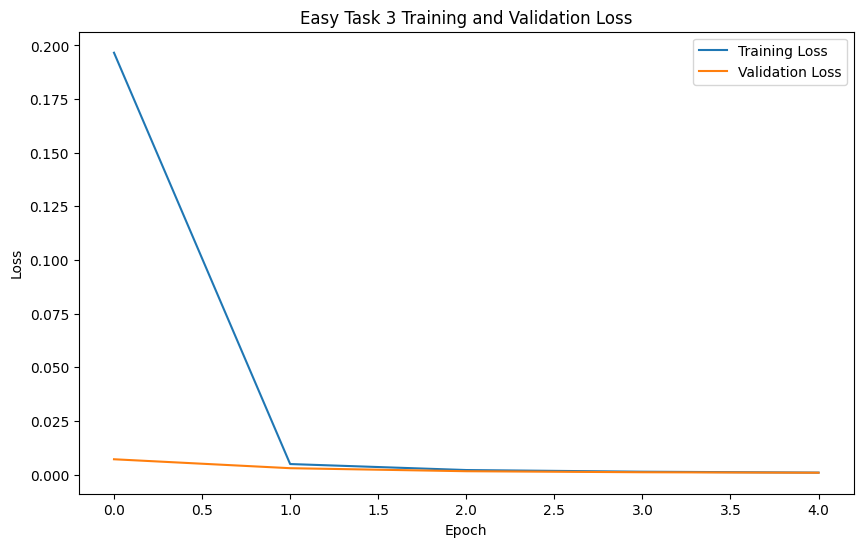

In [100]:
train_model(easy_data_list)